# NBA shot Analysis and Shot Predictor

In [690]:
#By Garrett Bunkers
import os
import numpy as np
import seaborn as sns
import scipy as sp
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
pd.set_option('display.max_columns', 100)


import itertools, math, time, re, pickle, shutil, requests

import ipywidgets as widgets
from ipywidgets import interact

import plotly as py
import plotly.graph_objs as go


import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, ShuffleSplit
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, auc, confusion_matrix, precision_score, recall_score, roc_curve, f1_score
from sklearn.preprocessing import MinMaxScaler, Normalizer, LabelEncoder

## Load and Combine Game Data from 2018-2022

In [645]:
path = "/Users/garrettbunkers/Documents/CS472/Project/game_data"
all_files = glob.glob(os.path.join(path, "*.csv"))
all_files

names = [os.path.basename(x) for x in all_files]
df = pd.DataFrame()

for file_, name in zip(all_files, names):
    file_df = pd.read_csv(file_, index_col=0)
    file_df['file_name'] = name
    df = df.append(file_df)
df

,Unnamed: 0.1,Unnamed: 0,match_id,shotX,shotY,quarter,time_remaining,player,team,made,shot_type,distance,score,opp,status,file_name
0,0,0,202008230BRK,40.3,23.6,1st quarter,11:29.0,Kyle Lowry,TOR,False,3-pointer,26,0-3,'TOR',trails,20200823.csv
1,1,1,202008230BRK,26.0,4.2,1st quarter,11:25.0,OG Anunoby,TOR,False,2-pointer,2,0-3,'TOR',trails,20200823.csv
2,2,2,202008230BRK,20.6,13.4,1st quarter,11:01.0,Pascal Siakam,TOR,False,2-pointer,11,0-6,'TOR',trails,20200823.csv
3,3,3,202008230BRK,23.9,11.3,1st quarter,10:54.0,Marc Gasol,TOR,True,2-pointer,8,2-6,'TOR',trails,20200823.csv
4,4,4,202008230BRK,25.9,5.4,1st quarter,10:19.0,Pascal Siakam,TOR,True,2-pointer,3,4-8,'TOR',trails,20200823.csv
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1021,1021,1021,202008060SAC,24.3,4.7,4th quarter,3:54.0,Richaun Holmes,SAC,False,2-pointer,1,136-118,'NOP',leads,20200806.csv
1022,1022,1022,202008060SAC,31.2,13.4,4th quarter,2:46.0,Bogdan Bogdanović,SAC,False,2-pointer,12,136-120,'NOP',leads,20200806.csv
1023,1023,1023,202008060SAC,41.2,21.5,4th quarter,2:13.0,De'Aaron Fox,SAC,False,3-pointer,25,136-120,'NOP',leads,20200806.csv
1024,1024,1024,202008060SAC,10.3,23.8,4th quarter,1:43.0,Kent Bazemore,SAC,False,3-pointer,25,136-120,'NOP',leads,20200806.csv


In [646]:
#Organzing and sorting dataframe
df = df.drop(["Unnamed: 0.1", "Unnamed: 0", "file_name", "opp", "score", "status", "time_remaining", "quarter"], axis = 1)
df = df.sort_values(by=['player'])
df = df.drop([df.index[0], df.index[1], df.index[2], df.index[3]])
df.shot_type = np.where(df.shot_type=='2-pointer', 2, 3)
df.made = np.where(df.made==True, 1, 0)
df

,match_id,shotX,shotY,player,team,made,shot_type,distance
50,201801050BOS,6.8,25.7,Aaron Brooks,MIN,0,3,28
1700,201804010MIN,24.2,3.4,Aaron Brooks,MIN,0,2,0
1699,201804010MIN,5.3,19.3,Aaron Brooks,MIN,1,3,24
1663,201804010MIN,8.2,25.2,Aaron Brooks,MIN,0,3,27
1659,201804010MIN,14.5,28.8,Aaron Brooks,MIN,0,3,27
...,...,...,...,...,...,...,...,...
623,201801280NOP,22.3,3.2,Ömer Aşık,NOP,1,2,1
625,201801280NOP,25.1,2.9,Ömer Aşık,NOP,1,2,1
1051,201801100MEM,24.5,4.7,Ömer Aşık,NOP,0,2,1
613,201801280NOP,24.0,5.9,Ömer Aşık,NOP,0,2,2


In [647]:
def get_shot_zone(row):
    x = row.shotX
    y = row.shotY
    dist = row.distance
    
    shot_zone = ''
    
    #shots within 4ft of hoop
    if dist<=4:
        shot_zone = 'Restricted Area'
       
    #above break 3 pointers
    elif (dist>=23) & (y>=16):
        shot_zone = 'Above Break 3'
    #corner 3s    
    elif (y<16) & ((x<=5) | (x>=45)):
        shot_zone = 'Corner 3'
    #in the paint shots excluding restricted area  
    elif (10<=y<=18) & (17<=x<=34) & (dist>4):
        shot_zone = 'Paint'
    #mid range shots, left and right side
    elif (dist<23) & ((3<x<17) | (34<x<47)):
        shot_zone = 'Mid Range'
    #mid range shots, center (above foul line)
    else:
        shot_zone = 'Mid Range'
    
    #heaves (defined as shots 35+ feet from basket)
    if dist>35:
        shot_zone = 'Heave'
   
    #Get area of court (left, right, or center)
    if shot_zone !='Paint':
        if x == 25:
            shot_area = 'C'
        elif (x>25):
            shot_area = 'L'
        else:
            shot_area = 'R'      
    #for shots in paint, they have special designation for left, right, and center
    else:
        if x>25:
            shot_area = 'L'
        elif x<25:
            shot_area = 'R'
        else:
            shot_area = 'C'
            
    return shot_zone, shot_area

In [648]:
def add_shot_zones_area_to_df(df):
    shot_zones = []
    shot_areas = []

    for index, row in df.iterrows():
        shot_zones.append(get_shot_zone(row)[0])
        shot_areas.append(get_shot_zone(row)[1])

    df['shot_zone'] = shot_zones
    df['shot_area'] = shot_areas

add_shot_zones_area_to_df(df)  
df

,match_id,shotX,shotY,player,team,made,shot_type,distance,shot_zone,shot_area
50,201801050BOS,6.8,25.7,Aaron Brooks,MIN,0,3,28,Above Break 3,R
1700,201804010MIN,24.2,3.4,Aaron Brooks,MIN,0,2,0,Restricted Area,R
1699,201804010MIN,5.3,19.3,Aaron Brooks,MIN,1,3,24,Above Break 3,R
1663,201804010MIN,8.2,25.2,Aaron Brooks,MIN,0,3,27,Above Break 3,R
1659,201804010MIN,14.5,28.8,Aaron Brooks,MIN,0,3,27,Above Break 3,R
...,...,...,...,...,...,...,...,...,...,...
623,201801280NOP,22.3,3.2,Ömer Aşık,NOP,1,2,1,Restricted Area,R
625,201801280NOP,25.1,2.9,Ömer Aşık,NOP,1,2,1,Restricted Area,L
1051,201801100MEM,24.5,4.7,Ömer Aşık,NOP,0,2,1,Restricted Area,R
613,201801280NOP,24.0,5.9,Ömer Aşık,NOP,0,2,2,Restricted Area,R


In [649]:
def get_lg_avgs(shot_zone_area_tup, df):
    sz = shot_zone_area_tup[0]
    sa = shot_zone_area_tup[1]
    shots_made = len(df[(df.shot_zone==sz) & (df.shot_area==sa) & (df.made==1)])
    total_shots = len(df[(df.shot_zone==sz) & (df.shot_area==sa)])
    if total_shots ==0:
        make_pct = 0
    else:
        make_pct = round((shots_made / total_shots),4)
    return make_pct

In [650]:
shot_zones = df.shot_zone
shot_areas = df.shot_area
sz = set(shot_zones)
sa = set(shot_areas)
sza_tups = list(itertools.product(sz,sa))

sza_dict = {}
for sza in sza_tups:
    sza_dict[sza] = get_lg_avgs(sza, df)

In [652]:
sza_dict

{('Heave', 'R'): 0.191,
 ('Heave', 'L'): 0.088,
 ('Heave', 'C'): 0.0,
 ('Mid Range', 'R'): 0.4054,
 ('Mid Range', 'L'): 0.4033,
 ('Mid Range', 'C'): 0.404,
 ('Paint', 'R'): 0.4287,
 ('Paint', 'L'): 0.4288,
 ('Paint', 'C'): 0.4678,
 ('Corner 3', 'R'): 0.3867,
 ('Corner 3', 'L'): 0.3815,
 ('Corner 3', 'C'): 0,
 ('Restricted Area', 'R'): 0.6503,
 ('Restricted Area', 'L'): 0.5403,
 ('Restricted Area', 'C'): 0.6414,
 ('Above Break 3', 'R'): 0.3509,
 ('Above Break 3', 'L'): 0.352,
 ('Above Break 3', 'C'): 0.3427}

In [653]:
def add_lg_avg_to_df(df):
    df['lg_avg']=0
    for k,v in sza_dict.items():
        df['lg_avg'] = np.where((df.shot_zone==k[0]) & (df.shot_area==k[1]), v, df['lg_avg'])

In [654]:
add_lg_avg_to_df(df)
df.tail()

,match_id,shotX,shotY,player,team,made,shot_type,distance,shot_zone,shot_area,lg_avg
623,201801280NOP,22.3,3.2,Ömer Aşık,NOP,1,2,1,Restricted Area,R,0.6503
625,201801280NOP,25.1,2.9,Ömer Aşık,NOP,1,2,1,Restricted Area,L,0.5403
1051,201801100MEM,24.5,4.7,Ömer Aşık,NOP,0,2,1,Restricted Area,R,0.6503
613,201801280NOP,24.0,5.9,Ömer Aşık,NOP,0,2,2,Restricted Area,R,0.6503
67,201804060BOS,23.1,3.0,Ömer Aşık,CHI,1,2,0,Restricted Area,R,0.6503


In [655]:
def get_fg_pct_by_player_for_each_zone(df):
    start = time.time()
    player_names = list(df.player.unique())
    df_list = []
    
    for c, player in enumerate(player_names):
        df_ = df[df.player==player].reset_index(drop=True)
        shot_arr = np.zeros((len(df_),26))

        if (c+1)%100==0:
            print('Runtime: {} seconds. {} of {} players completed.'.format(round(time.time()-start,2), c+1, len(player_names)))
        for index, row in df_.iterrows():
            if index != 0:
                shot_arr[index,:] = shot_arr[index-1,:]
            if row.shot_zone=='Mid Range':
                if row.shot_area=='R':
                    if row.made==1:
                        shot_arr[index,0:2]+=[1,1]
                    else:
                        shot_arr[index,0:2]+=[0,1]
                elif row.shot_area=='C':
                    if row.made==1:
                        shot_arr[index,2:4]+=[1,1]
                    else:
                        shot_arr[index,2:4]+=[0,1]
                else:
                    if row.made==1:
                        shot_arr[index,4:6]+=[1,1]
                    else:
                        shot_arr[index,4:6]+=[0,1]
            elif row.shot_zone=='Restricted Area':
                if row.made==1:
                    shot_arr[index,6:8]+=[1,1]
                else:
                    shot_arr[index,6:8]+=[0,1]
            elif row.shot_zone=='Heave':
                if row.made==1:
                    shot_arr[index,8:10]+=[1,1]
                else:
                    shot_arr[index,8:10]+=[0,1]
            elif row.shot_zone=='Above Break 3':
                if row.shot_area=='R':
                    if row.made==1:
                        shot_arr[index,10:12]+=[1,1]
                    else:
                        shot_arr[index,10:12]+=[0,1]
                elif row.shot_area=='C':
                    if row.made==1:
                        shot_arr[index,12:14]+=[1,1]
                    else:
                        shot_arr[index,12:14]+=[0,1]
                else:
                    if row.made==1:
                        shot_arr[index,14:16]+=[1,1]
                    else:
                        shot_arr[index,14:16]+=[0,1]
            elif row.shot_zone=='Paint':
                if row.shot_area=='R':
                    if row.made==1:
                        shot_arr[index,16:18]+=[1,1]
                    else:
                        shot_arr[index,16:18]+=[0,1]
                elif row.shot_area=='C':
                    if row.made==1:
                        shot_arr[index,18:20]+=[1,1]
                    else:
                        shot_arr[index,18:20]+=[0,1]
                else:
                    if row.made==1:
                        shot_arr[index,20:22]+=[1,1]
                    else:
                        shot_arr[index,20:22]+=[0,1]
            elif row.shot_zone=='Corner 3':
                if row.shot_area=='R':
                    if row.made==1:
                        shot_arr[index,22:24]+=[1,1]
                    else:
                        shot_arr[index,22:24]+=[0,1]
                else:
                    if row.made==1:
                        shot_arr[index,24:26]+=[1,1]
                    else:
                        shot_arr[index,24:26]+=[0,1]
        
        df_list.append(pd.DataFrame(shot_arr,index=df_.player))
    print('Total Runtime: {} seconds.'.format(round(time.time()-start,2),
                                              c, len(player_names)))
    return df_list

In [656]:
def add_zone_fg_pct_to_df(df):
    df_list = get_fg_pct_by_player_for_each_zone(df)
    zone_df = pd.concat([df_ for df_ in df_list])
    
    column_names = ['mid_R_pct', 'mid_C_pct', 'mid_L_pct', 'restricted_pct', 'heave_pct', 'ab_3_R_pct', 'ab_3_C_pct',
                'ab_3_L_pct', 'paint_R_pct', 'paint_C_pct', 'paint_L_pct', 'corner_3_R_pct', 'corner_3_L_pct',]    

    counter = 0
    for col in column_names:
        zone_df[col] = np.round(zone_df[counter]/zone_df[counter+1],4)
        counter+=2
    zone_df = zone_df.drop(columns=list(range(0,26))).reset_index().drop(columns={
                                                                    'player':'player_name'})
    
    print(zone_df)
    zone_fg_df = df.join(zone_df)
    
    return zone_fg_df


In [657]:
zone_fg_df = add_zone_fg_pct_to_df(df)

Runtime: 13.42 seconds. 100 of 971 players completed.
Runtime: 26.2 seconds. 200 of 971 players completed.
Runtime: 40.97 seconds. 300 of 971 players completed.
Runtime: 53.14 seconds. 400 of 971 players completed.
Runtime: 64.0 seconds. 500 of 971 players completed.
Runtime: 79.69 seconds. 600 of 971 players completed.
Runtime: 91.11 seconds. 700 of 971 players completed.
Runtime: 104.38 seconds. 800 of 971 players completed.
Runtime: 116.69 seconds. 900 of 971 players completed.
Total Runtime: 123.27 seconds.
        mid_R_pct  mid_C_pct  mid_L_pct  restricted_pct  heave_pct  ab_3_R_pct  ab_3_C_pct  ab_3_L_pct  paint_R_pct  paint_C_pct  paint_L_pct  corner_3_R_pct  corner_3_L_pct
0             NaN        NaN        NaN             NaN        NaN      0.0000         NaN         NaN          NaN          NaN          NaN             NaN             NaN
1             NaN        NaN        NaN          0.0000        NaN      0.0000         NaN         NaN          NaN          NaN       

In [658]:
#fill Nan values
zone_fg_df = zone_fg_df.fillna(value=0)

In [659]:
df = zone_fg_df
df.tail()

,match_id,shotX,shotY,player,team,made,shot_type,distance,shot_zone,shot_area,lg_avg,mid_R_pct,mid_C_pct,mid_L_pct,restricted_pct,heave_pct,ab_3_R_pct,ab_3_C_pct,ab_3_L_pct,paint_R_pct,paint_C_pct,paint_L_pct,corner_3_R_pct,corner_3_L_pct
2691,202105160WAS,0.8,5.3,Bradley Beal,WAS,0,3,23,Corner 3,R,0.3867,0.2945,0.0,0.2864,0.6373,0.0,0.2945,0.0,0.3614,0.3852,1.0,0.3762,0.3655,0.3802
2692,202105160WAS,22.7,8.8,Ish Smith,WAS,1,2,6,Mid Range,R,0.4054,0.2945,0.0,0.2864,0.6373,0.0,0.2945,0.0,0.3614,0.3852,1.0,0.3762,0.3655,0.3770
2693,202105160WAS,38.0,17.9,Ish Smith,WAS,0,2,20,Mid Range,L,0.4033,0.2945,0.0,0.2864,0.6366,0.0,0.2945,0.0,0.3614,0.3852,1.0,0.3762,0.3655,0.3770
2694,202105160WAS,24.5,18.2,Rui Hachimura,WAS,0,2,15,Mid Range,R,0.4054,0.2945,0.0,0.2864,0.6366,0.0,0.2945,0.0,0.3614,0.3821,1.0,0.3762,0.3655,0.3770
2695,202105160WAS,24.6,3.2,Robin Lopez,WAS,0,2,1,Restricted Area,R,0.6503,0.2945,0.0,0.2864,0.6366,0.0,0.2945,0.0,0.3614,0.3821,1.0,0.3725,0.3655,0.3770


In [660]:
df.to_csv('../shot_data/df_zones.csv')

In [661]:
#create dummies for shot_zone and shot_area
df = pd.concat([df,pd.get_dummies(df.shot_zone),
                pd.get_dummies(df.shot_area)],axis=1).drop(columns=['shot_zone','shot_area'])

In [663]:
df.tail()

,match_id,shotX,shotY,player,team,made,shot_type,distance,lg_avg,mid_R_pct,mid_C_pct,mid_L_pct,restricted_pct,heave_pct,ab_3_R_pct,ab_3_C_pct,ab_3_L_pct,paint_R_pct,paint_C_pct,paint_L_pct,corner_3_R_pct,corner_3_L_pct,Above Break 3,Corner 3,Heave,Mid Range,Paint,Restricted Area,C,L,R
2691,202105160WAS,0.8,5.3,Bradley Beal,WAS,0,3,23,0.3867,0.2945,0.0,0.2864,0.6373,0.0,0.2945,0.0,0.3614,0.3852,1.0,0.3762,0.3655,0.3802,0,1,0,0,0,0,0,0,1
2692,202105160WAS,22.7,8.8,Ish Smith,WAS,1,2,6,0.4054,0.2945,0.0,0.2864,0.6373,0.0,0.2945,0.0,0.3614,0.3852,1.0,0.3762,0.3655,0.3770,0,0,0,1,0,0,0,0,1
2693,202105160WAS,38.0,17.9,Ish Smith,WAS,0,2,20,0.4033,0.2945,0.0,0.2864,0.6366,0.0,0.2945,0.0,0.3614,0.3852,1.0,0.3762,0.3655,0.3770,0,0,0,1,0,0,0,1,0
2694,202105160WAS,24.5,18.2,Rui Hachimura,WAS,0,2,15,0.4054,0.2945,0.0,0.2864,0.6366,0.0,0.2945,0.0,0.3614,0.3821,1.0,0.3762,0.3655,0.3770,0,0,0,1,0,0,0,0,1
2695,202105160WAS,24.6,3.2,Robin Lopez,WAS,0,2,1,0.6503,0.2945,0.0,0.2864,0.6366,0.0,0.2945,0.0,0.3614,0.3821,1.0,0.3725,0.3655,0.3770,0,0,0,0,0,1,0,0,1


In [380]:
df.to_csv('../shot_data/df_1822.csv')

### Get Train and Test Data

In [342]:
X = df.drop(columns=['match_id','player','team','made','shot_type','distance',
                     'Above Break 3', 'Corner 3', 'Mid Range', 'Paint','Restricted Area', 'C', 'L', 'R',])
y = df.made

In [352]:
X.columns

Index(['shotX', 'shotY', 'lg_avg', 'mid_R_pct', 'mid_C_pct', 'mid_L_pct', 'restricted_pct', 'heave_pct', 'ab_3_R_pct', 'ab_3_C_pct', 'ab_3_L_pct', 'paint_R_pct', 'paint_C_pct', 'paint_L_pct', 'corner_3_R_pct', 'corner_3_L_pct', 'Heave'], dtype='object')

## Models

### Model Build

In [345]:
def build_model(model, X_train, X_test, y_train, y_test, decision_function=True):
    start = time.time()
    
    clf = model
    clf.fit(X_train,y_train)  
    y_hat_test = clf.predict(X_test)
      
    if decision_function==True:
        y_score = clf.decision_function(X_test)
    else:
        y_score = clf.predict_proba(X_test)[:, 1]
    
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    print('Total Runtime: {} seconds'.format(time.time()-start))
    
    return clf, y_hat_test, y_score, fpr, tpr, thresholds

### Feature Importance

In [346]:
def plot_feature_importances(model):
    n_features = len(X.columns)
    plt.figure(figsize=(14,10))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X.columns.values) 
    plt.xlabel("Feature importance")
    plt.ylabel("Features")

### Confusion Matrix

In [363]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    #Create the basic matrix.
    plt.imshow(cm, cmap)
    
    #Add title and Axis Labels
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    #Add appropriate Axis Scales
    class_names = ['Miss','Make']
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    
    #Add Labels to Each Cell
    thresh = cm.max()*.75
    
    #Add a Side Bar Legend Showing Colors
    plt.colorbar()
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

### Plot Matrix

In [348]:
def print_model_metrics(y_pred,y_score):
    cm = confusion_matrix(y_test, y_pred)
    #print(cm)
    true_negative, false_positive, false_negative, true_positive = cm[0,0], cm[0,1], cm[0,1], cm[0,1]

    plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues)

    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    recall = recall_score(y_test,y_pred)
    f1 = f1_score(y_test,y_pred)
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    
    #print('Training Set Metrics:')
    print('Accuracy:   {}'.format(round(accuracy,4)))
    print('Precision:  {}'.format(round(precision,4)))
    print('Recall:     {}'.format(round(recall,4)))
    print('F1          {}'.format(round(f1,4)))
    print('AUC:        {}'.format(round(auc(fpr, tpr),4)))

### Plot ROC Curve

In [349]:
def plot_roc_curve(fpr, tpr):
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})

    plt.figure(figsize=(10,6))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.yticks([i/20.0 for i in range(21)])
    plt.xticks([i/20.0 for i in range(21)])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

### Logistic Regression Model

In [357]:
log_reg, log_y_preds, log_y_score, log_fpr, log_tpr, log_thresholds= build_model(LogisticRegression(
                                                                                C=1, class_weight='balanced'),
                                                                                X_train, X_test,
                                                                                y_train, y_test)

Total Runtime: 4.945903301239014 seconds


Accuracy:   0.6207
Precision:  0.6238
Recall:     0.4467
F1          0.5206
AUC:        0.628


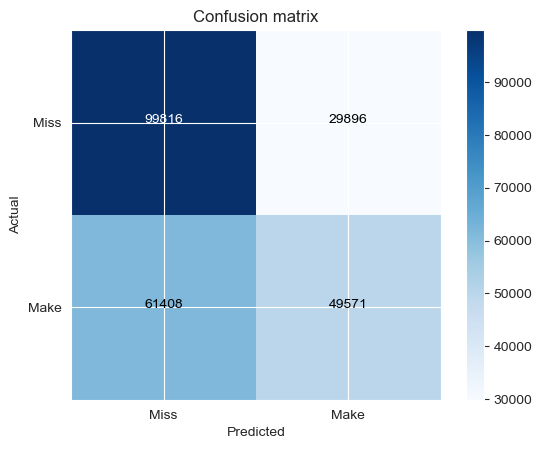

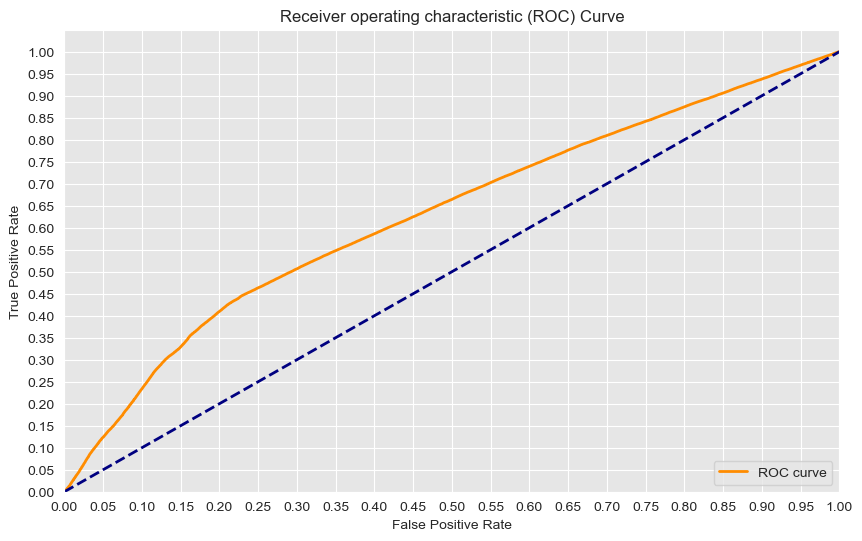

In [364]:
print_model_metrics(log_y_preds, log_y_score)
plot_roc_curve(log_fpr, log_tpr)

### Random Forest Model

In [359]:
rf, rf_y_preds, rf_y_score, rf_fpr, rf_tpr, rf_thresholds = build_model(RandomForestClassifier(
                                                                        n_estimators=500, criterion='entropy',
                                                                        max_features='sqrt',min_samples_leaf=10,
                                                                        min_samples_split=10, verbose=1,
                                                                        class_weight='balanced',n_jobs=2,
                                                                        random_state=23),
                                                                        X_train, X_test, y_train, y_test,
                                                                        decision_function=False)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  1.1min
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:  4.4min
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed: 10.0min
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed: 11.2min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    2.2s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    9.2s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:   20.5s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:   23.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.9s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    7.4s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:   17.0s


Total Runtime: 714.4024939537048 seconds


[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:   18.9s finished


Accuracy:   0.6115
Precision:  0.602
Recall:     0.4645
F1          0.5244
AUC:        0.628


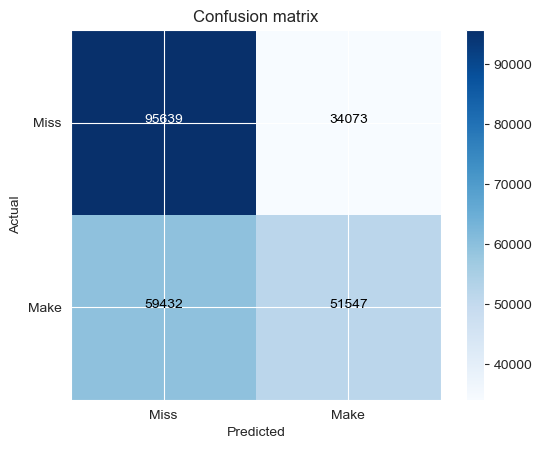

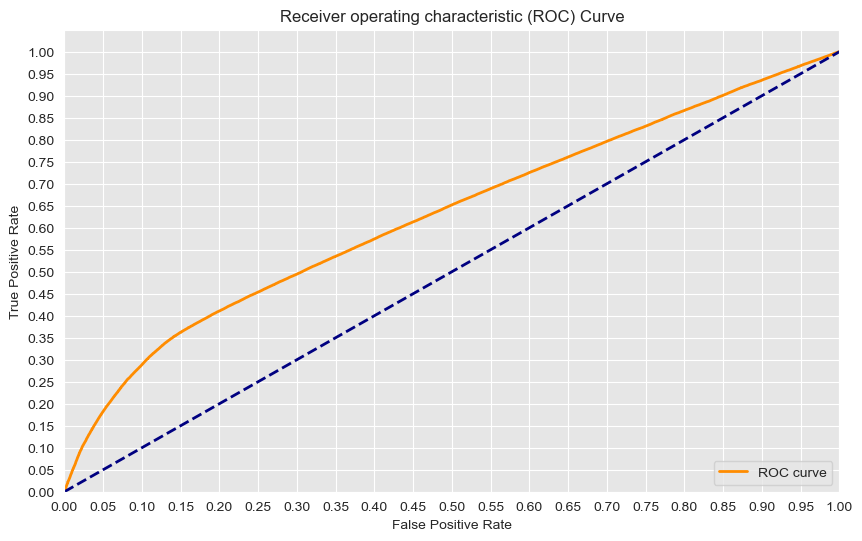

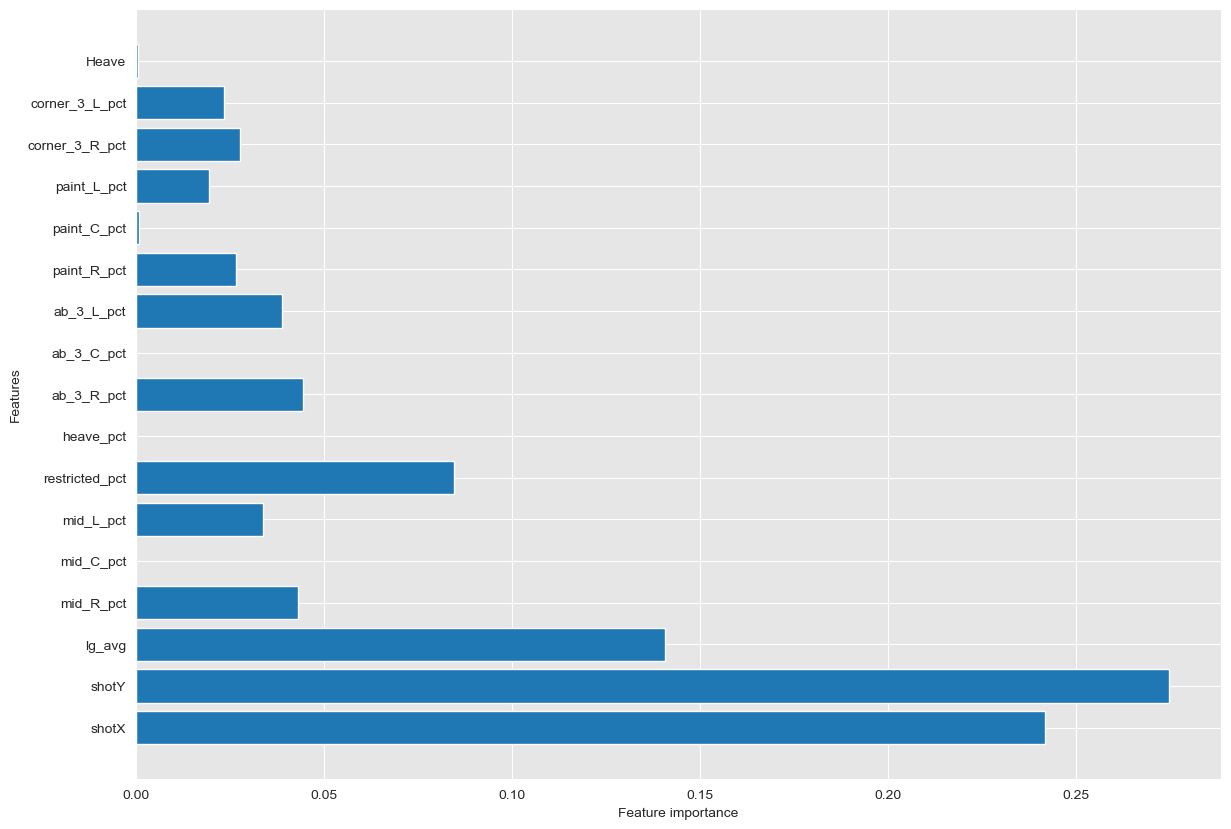

In [360]:
print_model_metrics(rf_y_preds, rf_y_score)
plot_roc_curve(rf_fpr, rf_tpr)
plot_feature_importances(rf)

### Gradient Boosting Model

In [365]:
gb, gb_y_preds, gb_y_score, gb_fpr, gb_tpr, gb_thresholds = build_model(GradientBoostingClassifier(
                                                                        learning_rate=.1, n_estimators=100, 
                                                                        max_depth=5, min_samples_leaf=5,
                                                                        min_samples_split=5, verbose=1, 
                                                                        random_state=23),
                                                                        X_train, X_test, y_train, y_test)

      Iter       Train Loss   Remaining Time 
         1           1.3668            3.43m
         2           1.3555            3.27m
         3           1.3464            3.18m
         4           1.3389            3.15m
         5           1.3326            3.10m
         6           1.3276            3.04m
         7           1.3234            3.00m
         8           1.3199            2.94m
         9           1.3170            2.92m
        10           1.3145            2.88m
        20           1.3032            2.54m
        30           1.3007            2.24m
        40           1.2999            1.93m
        50           1.2994            1.61m
        60           1.2990            1.29m
        70           1.2987           58.78s
        80           1.2984           39.14s
        90           1.2982           19.54s
       100           1.2979            0.00s
Total Runtime: 197.28560996055603 seconds


Accuracy:   0.6304
Precision:  0.6765
Recall:     0.3802
F1          0.4868
AUC:        0.6393


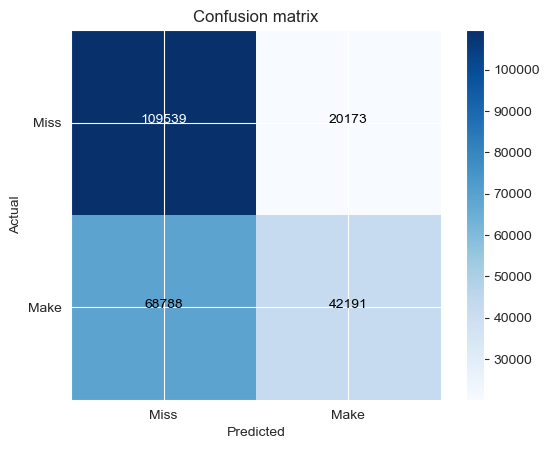

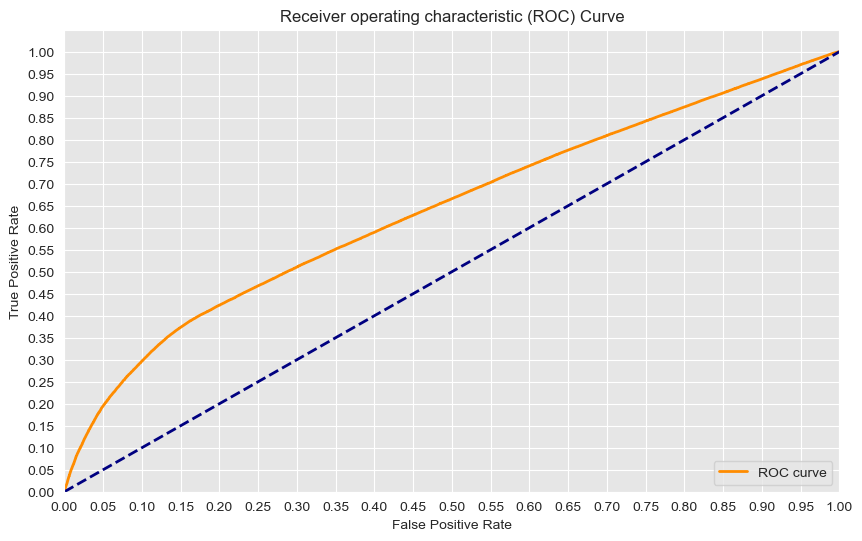

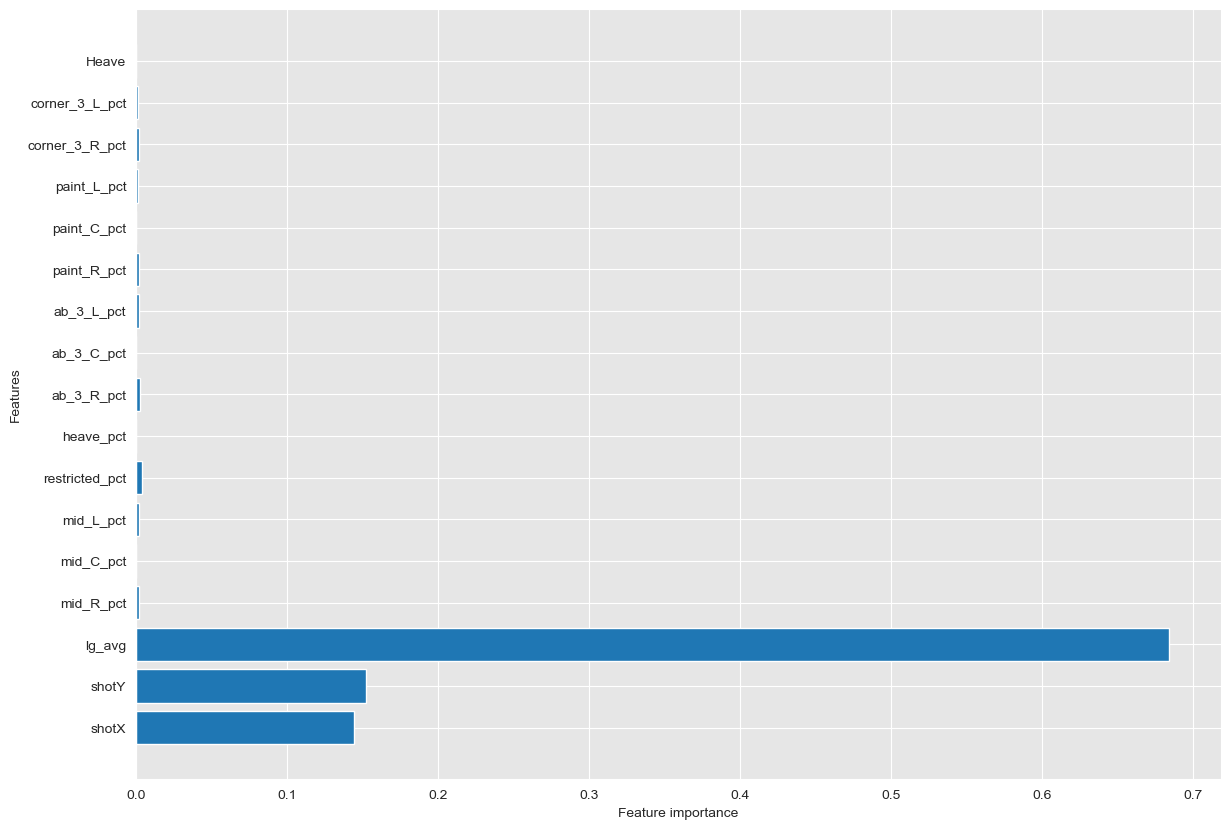

In [366]:
print_model_metrics(gb_y_preds, gb_y_score)
plot_roc_curve(gb_fpr, gb_tpr)
plot_feature_importances(gb)


## Visuals

In [605]:
from matplotlib.patches import Circle, Rectangle, Arc

def draw_court(ax=None, color='black', lw=2, outer_lines=False):
    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        ax = plt.gca()

    # Create the various parts of an NBA basketball court

    # Create the basketball hoop
    # Diameter of a hoop is 18" so it has a radius of 9", which is a value
    # 7.5 in our coordinate system
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

    # Create backboard
    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)

    # The paint
    # Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False)
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False)

    # Create free throw top arc
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed')
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color)

    # Three point line
    # Create the side 3pt lines, they are 14ft long before they begin to arc
    corner_three_a = Rectangle((-220, -47.5), 0, 140, linewidth=lw,
                               color=color)
    corner_three_b = Rectangle((220, -47.5), 0, 140, linewidth=lw, color=color)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    # I just played around with the theta values until they lined up with the 
    # threes
    three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw,
                    color=color)

    # Center Court
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color)

    # List of the court elements to be plotted onto the axes
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc, center_outer_arc,
                      center_inner_arc]

    if outer_lines:
        # Draw the half court line, baseline and side out bound lines
        outer_lines = Rectangle((-250, -47.5), 500, 470, linewidth=lw,
                                color=color, fill=False)
        court_elements.append(outer_lines)

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax

### Frequency Shooting Plot

In [595]:
def find_shootingPcts(shot_df, gridNum):
    x2 = shot_df.shotX[(shot_df['shotY']<425.1) & (shot_df.shot_type==2)]
    y2 = shot_df.shotY[(shot_df['shotY']<425.1) & (shot_df.shot_type==2)]

    x2_made = shot_df.shotX[(shot_df['made']==1) & (shot_df['shotY']<425.1) & (shot_df.shot_type==2)]
    y2_made = shot_df.shotY[(shot_df['made']==1) & (shot_df['shotY']<425.1) & (shot_df.shot_type==2)]

    #compute number of shots made and taken from each hexbin location
    hb_shot2 = plt.hexbin(x2, y2, gridsize=gridNum, extent=(-250,250,425,-50));
    plt.close()
    hb_made2 = plt.hexbin(x2_made, y2_made, gridsize=gridNum, extent=(-250,250,425,-50),cmap=plt.cm.Reds);
    plt.close()

    #compute shooting percentage
    ShootingPctLocs2 = hb_made2.get_array() / hb_shot2.get_array()
    ShootingPctLocs2[np.isnan(ShootingPctLocs2)] = 0 #makes 0/0s=0
    
    #############################################################################################################
    #############################################################################################################
    ###########################################  THREE POINTERS  ################################################
    #############################################################################################################
    #############################################################################################################
    
    x3 = shot_df.shotX[(shot_df['shotY']<425.1) & (shot_df.shot_type==3)]
    y3 = shot_df.shotY[(shot_df['shotY']<425.1) & (shot_df.shot_type==3)]

    x3_made = shot_df.shotX[(shot_df['made']==1) & (shot_df['shotY']<425.1) & (shot_df.shot_type==3)]
    y3_made = shot_df.shotY[(shot_df['made']==1) & (shot_df['shotY']<425.1) & (shot_df.shot_type==3)]

    #compute number of shots made and taken from each hexbin location
    hb_shot3 = plt.hexbin(x3, y3, gridsize=gridNum, extent=(-250,250,425,-50));
    plt.close()
    hb_made3 = plt.hexbin(x3_made, y3_made, gridsize=gridNum, extent=(-250,250,425,-50),cmap=plt.cm.Reds);
    plt.close()

    #compute shooting percentage
    ShootingPctLocs3 = hb_made3.get_array() / hb_shot3.get_array()
    ShootingPctLocs3[np.isnan(ShootingPctLocs3)] = 0 #makes 0/0s=0
    
    return (ShootingPctLocs2, hb_shot2, ShootingPctLocs3, hb_shot3)

In [607]:
def freq_shooting_plot(player_name,gridNum=35, twos=True, threes=True):
    shot_df = df[df.player==player_name]
    shot_df.shotX = 9 * shot_df.shotX
    shot_df.shotY = 9 * shot_df.shotY
    shot_df.shotX = shot_df.shotX - 217
    shot_df.shotY = shot_df.shotY - 35
    
    #compute shooting percentage and # of shots
    (ShootingPctLocs2, shotNumber2) = find_shootingPcts(shot_df, gridNum)[0:2]
    (ShootingPctLocs3, shotNumber3) = find_shootingPcts(shot_df, gridNum)[2:]
    
    fig = plt.figure(figsize=(12,11))
    ax = plt.axes([0.1, 0.1, 0.8, 0.8]) #where to place the plot within the figure
    draw_court()
    # Adjust plot limits to just fit in half court
    plt.xlim(-250,250)
    # Descending values along th y axis from bottom to top
    # in order to place the hoop by the top of plot
    plt.ylim(400, -25)
    #422.5, -47.5
    if twos==True:
        cmap = mymap.from_list('Color Map',[(0,'#ff0000'),(.45,'#ffff00'),(.6,'#00ff00'), (1,'#004d00')])
        #draw circles
        for i, shots in enumerate(ShootingPctLocs2):
            restricted2 = Circle(shotNumber2.get_offsets()[i], radius=shotNumber2.get_array()[i],
                                color=cmap(shots),alpha=1, fill=True)
            if restricted2.radius > 240/gridNum: restricted2.radius=240/gridNum
            ax.add_patch(restricted2)

        #draw color bar
        ax2 = fig.add_axes([0.95, 0.1, 0.02, 0.8])
        cb = matplotlib.colorbar.ColorbarBase(ax2,cmap=cmap, orientation='vertical')
        cb.set_label('Field Goal %', labelpad=20)
        cb.set_ticks([0.0, 0.25, .485, 0.75, 1.0])
        cb.set_ticklabels(['0%','25%','48.5%\nLg Avg', '75%', '100%'])
    if threes==True:
        #plotting 3 pointers separately to account for expected lower fg% from deep
        cmap3 = mymap.from_list('Color Map',[(0,'#ff0000'),(.35,'#ffff00'),(.6,'#00ff00'),(1,'#004d00')])
        #draw circles
        for i, shots in enumerate(ShootingPctLocs3):
            restricted3 = Circle(shotNumber3.get_offsets()[i], radius=shotNumber3.get_array()[i],
                                color=cmap3(shots),alpha=1, fill=True)
            if restricted3.radius > 240/gridNum: restricted3.radius=240/gridNum
            ax.add_patch(restricted3)

        #draw color bar
        ax3 = fig.add_axes([1.1, 0.1, 0.02, 0.8])
        cb3 = matplotlib.colorbar.ColorbarBase(ax3,cmap=cmap3, orientation='vertical')
        cb3.set_label('Three Point %',labelpad=-8)
        cb3.set_ticks([0.0, 0.25,.35, 0.5, 0.75, 1.0])
        cb3.set_ticklabels(['0%','25%','35% - Lg Avg', '50%','75%', '100%'])
        
    ax.set_title(shot_df.player.unique()[0] +' - Shot Chart 2018-22', fontsize = 16)
    plt.show()

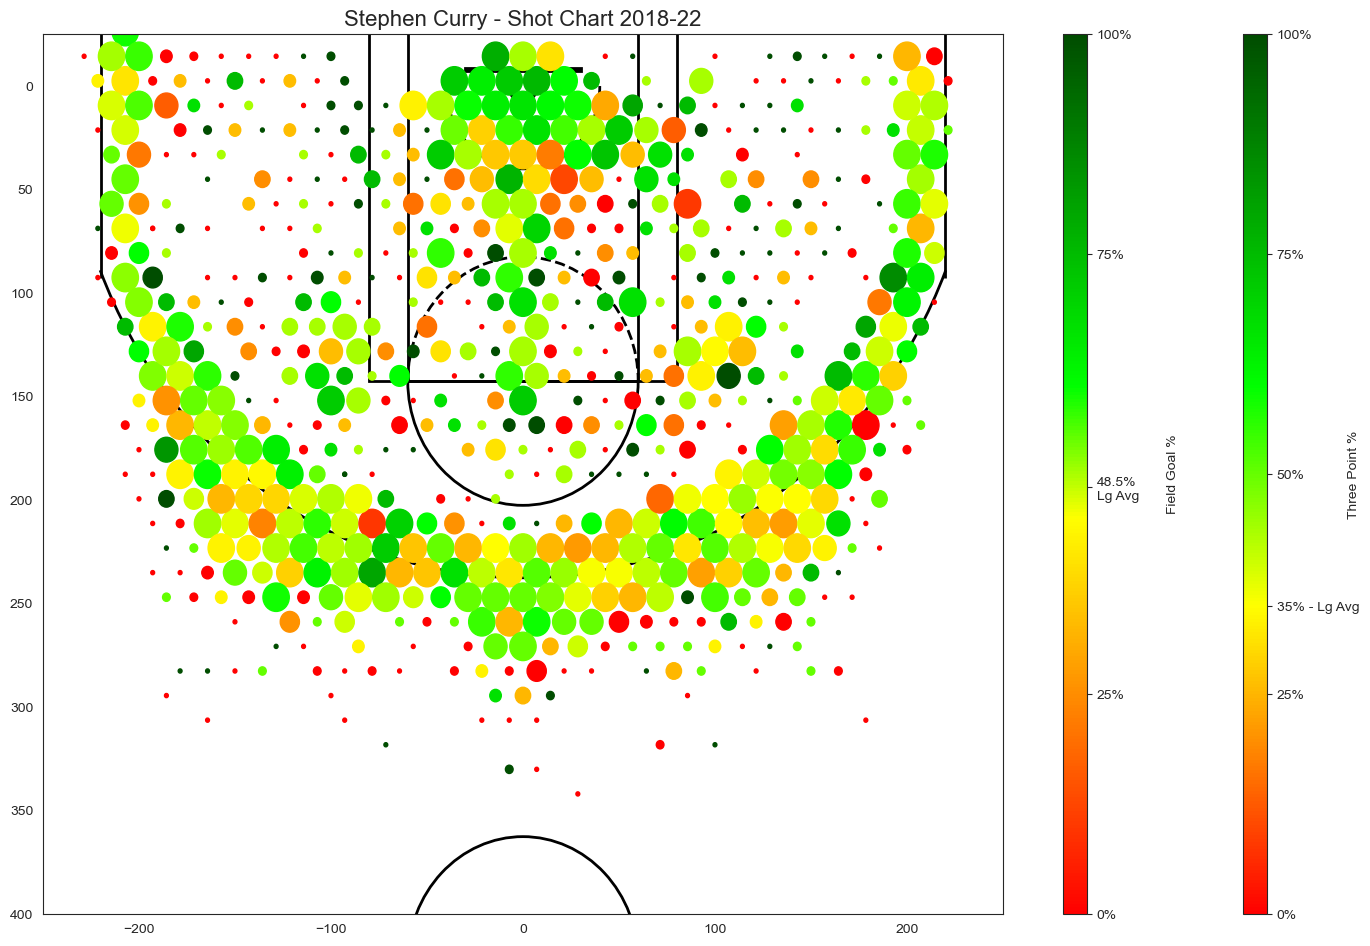

In [608]:
#Input any player name
#it will ouput a map of shots they make the most(green)
#and shots they make the least(red)
freq_shooting_plot('Stephen Curry')

In [666]:
def team_freq_shooting_plot(team_name,gridNum=35, twos=True, threes=True):
    shot_df = df[df.team==team_name]
    shot_df.shotX = 9 * shot_df.shotX
    shot_df.shotY = 9 * shot_df.shotY
    shot_df.shotX = shot_df.shotX - 217
    shot_df.shotY = shot_df.shotY - 35
    
    #compute shooting percentage and # of shots
    (ShootingPctLocs2, shotNumber2) = find_shootingPcts(shot_df, gridNum)[0:2]
    (ShootingPctLocs3, shotNumber3) = find_shootingPcts(shot_df, gridNum)[2:]
    
    fig = plt.figure(figsize=(12,11))
    ax = plt.axes([0.1, 0.1, 0.8, 0.8]) #where to place the plot within the figure
    draw_court()
    # Adjust plot limits to just fit in half court
    plt.xlim(-250,250)
    # Descending values along th y axis from bottom to top
    # in order to place the hoop by the top of plot
    plt.ylim(400, -25)
    #422.5, -47.5
    if twos==True:
        cmap = mymap.from_list('Color Map',[(0,'#ff0000'),(.45,'#ffff00'),(.6,'#00ff00'), (1,'#004d00')])
        #draw circles
        for i, shots in enumerate(ShootingPctLocs2):
            restricted2 = Circle(shotNumber2.get_offsets()[i], radius=shotNumber2.get_array()[i],
                                color=cmap(shots),alpha=1, fill=True)
            if restricted2.radius > 240/gridNum: restricted2.radius=240/gridNum
            ax.add_patch(restricted2)

        #draw color bar
        ax2 = fig.add_axes([0.95, 0.1, 0.02, 0.8])
        cb = matplotlib.colorbar.ColorbarBase(ax2,cmap=cmap, orientation='vertical')
        cb.set_label('Field Goal %', labelpad=20)
        cb.set_ticks([0.0, 0.25, .485, 0.75, 1.0])
        cb.set_ticklabels(['0%','25%','48.5%\nLg Avg', '75%', '100%'])
    if threes==True:
        #plotting 3 pointers separately to account for expected lower fg% from deep
        cmap3 = mymap.from_list('Color Map',[(0,'#ff0000'),(.35,'#ffff00'),(.6,'#00ff00'),(1,'#004d00')])
        #draw circles
        for i, shots in enumerate(ShootingPctLocs3):
            restricted3 = Circle(shotNumber3.get_offsets()[i], radius=shotNumber3.get_array()[i],
                                color=cmap3(shots),alpha=1, fill=True)
            if restricted3.radius > 240/gridNum: restricted3.radius=240/gridNum
            ax.add_patch(restricted3)

        #draw color bar
        ax3 = fig.add_axes([1.1, 0.1, 0.02, 0.8])
        cb3 = matplotlib.colorbar.ColorbarBase(ax3,cmap=cmap3, orientation='vertical')
        cb3.set_label('Three Point %',labelpad=-8)
        cb3.set_ticks([0.0, 0.25,.35, 0.5, 0.75, 1.0])
        cb3.set_ticklabels(['0%','25%','35% - Lg Avg', '50%','75%', '100%'])
        
    ax.set_title(shot_df.team.unique()[0] +' - Shot Chart 2018-22', fontsize = 16)
    plt.show()

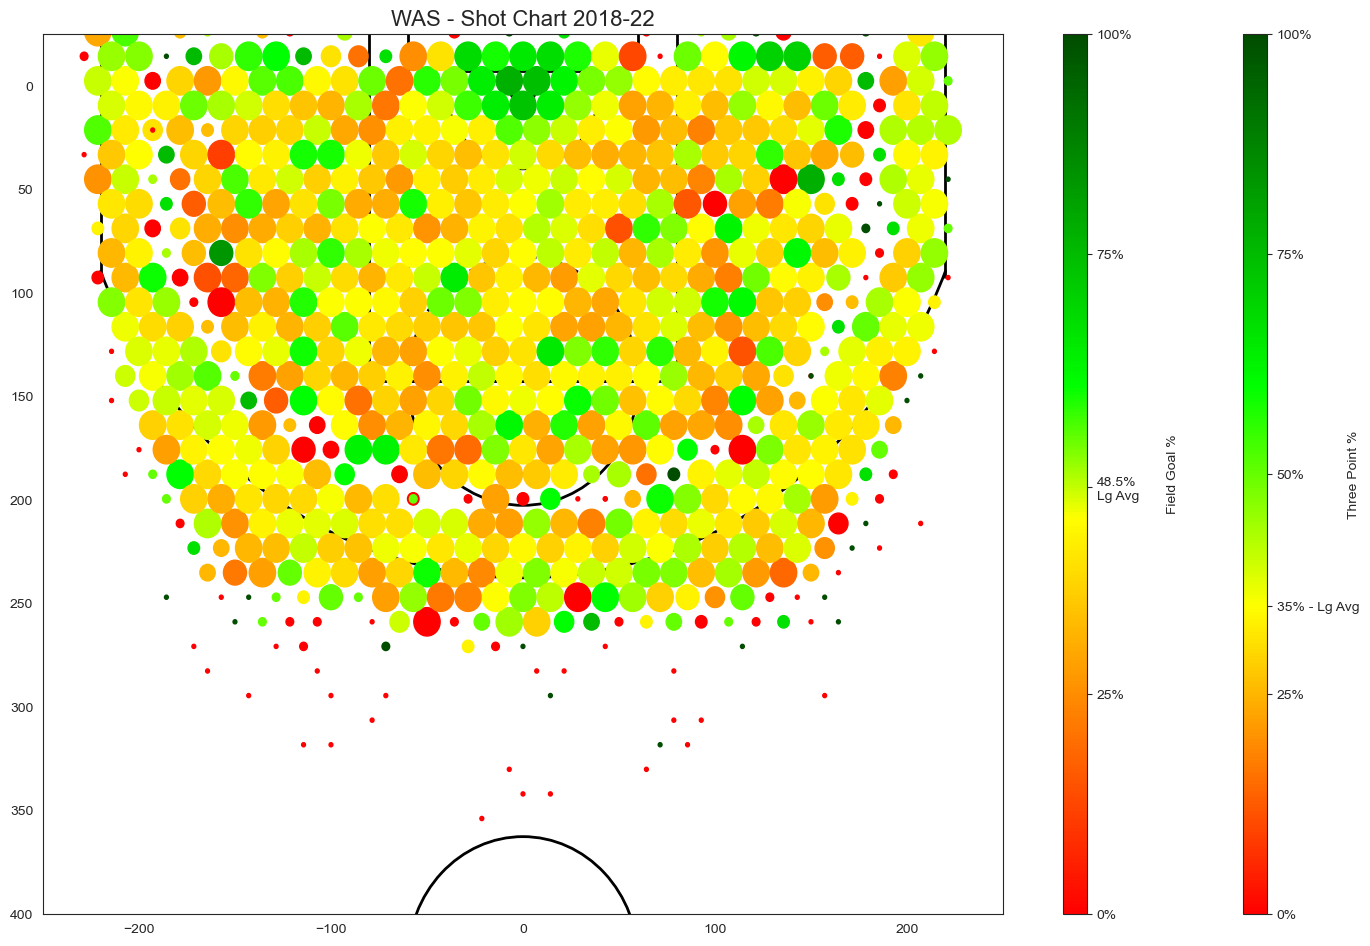

In [667]:
#Input any team acronym
#it will ouput a map of shots they make the most(green)
#and shots they make the least(red)
team_freq_shooting_plot("WAS")

## Poor Attempt at Shot Recommender 

In [688]:
def predict_shot(player, zone, fg_pct):
    df = pd.read_csv('../shot_data/df_zones.csv')
    le = LabelEncoder()
    df['player'] = le.fit_transform(df['player'])
    df['shot_zone'] = le.fit_transform(df['shot_zone'])
    X_train, X_test, y_train, y_test = train_test_split(data[['player', 'shot_zone', 'lg_avg']], data['made'], test_size=0.2, random_state=0)
    model = LogisticRegression()
    model.fit(X_train, y_train)
    
    # Encode the categorical variables
    player = le.transform([player])[0]
    zone = le.transform([zone])[0]
    
    # Make a prediction
    pred = model.predict([[player, zone, fg_pct]])
    
    # Return the prediction
    return pred[0]

In [689]:
print(predict_shot('James Harden', 'Mid-Range', 0.45))
# Output: 1 (the shot is predicted to go in)

print(predict_shot('LeBron James', 'Corner 3', 0.38))
# Output: 0 (the shot is predicted to miss)

KeyError: "None of [Index(['player', 'shot_zone'], dtype='object')] are in the [columns]"